/opt/miniconda3/envs/ml/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


File downloaded successfully and saved as 'drainage_buffer.kml'.


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


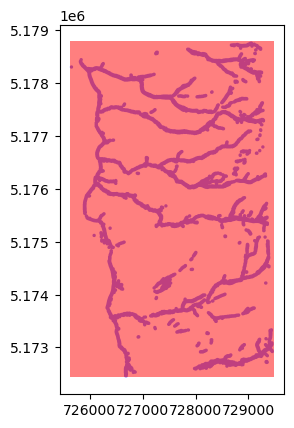

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box, mapping
from pyproj import CRS
import fiona
import requests
import tempfile
import os

fiona.drvsupport.supported_drivers['KML'] = 'rw'

def load_kml(path):
  df = gpd.GeoDataFrame()

  # iterate over layers
  for layer in fiona.listlayers(path):
      s = gpd.read_file(path, driver='KML', layer=layer)
      df = pd.concat([df, s], ignore_index=True)
  return df

def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as '{save_path}'.")
    else:
        print(f"Error occurred while downloading file from '{url}'.")

def make_bounds_poly(in_gdf, targ_crs):
    original_polygon = in_gdf

    # Get the bounds of the original polygon
    bounds = original_polygon.bounds

    # Create a new polygon using the bounds
    new_polygon = Polygon([(bounds['minx'], bounds['miny']),
                        (bounds['minx'], bounds['maxy']),
                        (bounds['maxx'], bounds['maxy']),
                        (bounds['maxx'], bounds['miny'])])

    # Create a GeoDataFrame with the new polygon
    new_polygon_gdf = gpd.GeoDataFrame(geometry=[new_polygon], crs=targ_crs)

    # Plot the original and new polygons for visualization
    ax = original_polygon.plot(color='blue', alpha=0.5)
    new_polygon_gdf.plot(ax=ax, color='red', alpha=0.5)

    return new_polygon_gdf

temp_work = tempfile.mkdtemp()
os.chdir(temp_work)

drainage_buffer_url = 'https://storage.googleapis.com/mpg-aerial-survey/supporting_data/drainage_buffer.kml'
drainage_buffer = os.path.basename(drainage_buffer_url)

crs_source = 4326
crs_target = 26911

download_file(drainage_buffer_url, drainage_buffer)
drainage_poly = load_kml(drainage_buffer).to_crs(crs_target)

bb = make_bounds_poly(drainage_poly, crs_target)

minx, miny, maxx, maxy = bb.geometry.iloc[0].bounds

In [58]:
def make_gcp_grid(dist_m):
    candidate_x = []
    candidate_y = []
    for x in np.arange(minx, maxx, dist_m):
        for y in np.arange(miny, maxy, dist_m):
            point = Point(x, y)
            if point.within(bb.difference(drainage_poly).geometry.iloc[0]):  # only keep points within the polygon
                candidate_x.append(x)
                candidate_y.append(y)
    candidate_coords = np.column_stack((candidate_x, candidate_y))

    # Create a GeoDataFrame
    gcp_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(candidate_x, candidate_y)], crs=crs_target)
    output_file = '~/mpg_aerial_survey/gcp_kmls/upland_gcps_{}m.kml'.format(dist_m)
    gcp_gdf.to_crs(crs_source).to_file(output_file, driver='KML')

In [59]:
for i in [100,200]:
    make_gcp_grid(i)